All imports

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import random
import math
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform, cityblock, mahalanobis
from scipy.linalg import inv
from tqdm import tqdm

Function for generating the graph

In [ ]:
# Graph Gen 1.2
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
# Ensured the following:
# The input nodes must have at least one outgoing edge and no incoming edge
# The output nodes must have one incoming edge only
# Internal nodes must have at least one incoming and at least one outgoing edge

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    enable_power=True,
    enable_wire_count=True,
    enable_distance=True,
    seed=42
):
    G = nx.DiGraph()
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    for node in input_nodes + output_nodes:
        G.add_node(node)

    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes


Agglomerative Clustering

In [ ]:
def perform_agglomerative_clustering(G, num_clusters):
    # This function clusters the nodes of a graph G using Agglomerative Clustering, while optimizing based on power and area constraints.
    # Performs Agglomerative Clustering using following methods
    # 1. complete: Merges clusters based on the maximum distance between points in two clusters, ensures tightly bound clusters
    # 2. single: distance between two clusters is defined as the minimum distance between any two points in each cluster, forms long, chain like clusters
    # 3. average: distance between two clusters is the average of all pairwise distances between points in each cluster, tends to produce moderate-sized clusters
    # 4. centroid: distance between two clusters is the distance between their centroids (mean points)
    # 5. ward's linkage: Minimizes the increase in total within-cluster variance when merging two clusters, produces compact, equally sized clusters.

    node_features = []
    node_names = []
    for node in G.nodes():
        power = G.nodes[node].get('power', 0)
        area = G.nodes[node].get('area', 0)
        node_features.append([power, area])
        node_names.append(node)

    node_features = np.array(node_features)

    distance_metric = 'mahalanobis'
    linkage_method = 'single'

    # Computes the pairwise distance matrix based on the selected metric:
    # 1. Cityblock (Manhattan) Distance: Measures the absolute difference between feature values.
    # 2. Mahalanobis Distance: Accounts for correlations between power and area, making clustering more accurate in high-dimensional spaces.

    if distance_metric == 'cityblock':
        dist_matrix = pdist(node_features, metric='cityblock')  # Manhattan Distance
    elif distance_metric == 'mahalanobis':
        VI = inv(np.cov(node_features.T))  # Compute inverse covariance matrix
        dist_matrix = pdist(node_features, metric='mahalanobis', VI=VI)
    else:
        raise ValueError("Unsupported distance metric. Use 'cityblock' or 'mahalanobis'.")

    # Perform hierarchical clustering and assigning cluster labels to each node
    linkage_matrix = linkage(dist_matrix, method=linkage_method)
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # storing the assigned cluster ID for each node.
    cluster_dict = {node_names[i]: clusters[i] for i in range(len(node_names))}
    nx.set_node_attributes(G, cluster_dict, 'cluster')

    return G, cluster_dict

def calculate_wire_cut_and_length(G, cluster_dict):
    # This function calculates edge cuts and total wire length based on inter-cluster and intra-cluster connections.
    # the wire remains unscaled when its a intra-cluster edge and it gets scaled by 10x to penalize cross-cluster connections when its a inter cluster edge

    edge_cuts, total_wire_length = 0, 0
    scaling_factor = 10

    for u, v, data in G.edges(data=True):
        wire_length = data.get('distance', 1)
        if cluster_dict.get(u) == cluster_dict.get(v):  # Intra-cluster
            total_wire_length += wire_length
        else:  # Inter-cluster
            total_wire_length += scaling_factor * wire_length
            edge_cuts += 1

    return edge_cuts, total_wire_length

def find_critical_path(G):
    # This function finds the critical path in the graph G based on the longest delay, where the delay is defined as L^2 (distance squared for each edge in the path)
    # This one uses Dijkstra’s Algorithm to find the shortest path from source to target (minimising distance)
    # Computes the delay as the sum of squares of edge distances, then returns the longest delay path and the corresponding maximum delay

    longest_path = None
    max_delay = 0

    for source in G.nodes():
        for target in G.nodes():
            if source != target and nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target, weight='distance')
                path_delay = sum(G[u][v]['distance'] for u, v in zip(path, path[1:]))
                if path_delay > max_delay:
                    max_delay = path_delay
                    longest_path = path

    return longest_path, max_delay
# Borrowed from KMeans_1d.ipynb
# Computes number of inter-cluster cuts, wire length, and delay

def compute_wire_metrics(G, cluster_labels, input_nodes, output_nodes):
    num_cuts = 0
    total_wire_length = 0
    G_weighted = nx.DiGraph()

    for u, v in G.edges():
        wire_length = G.edges[u, v].get("distance", 1)
        cluster_u, cluster_v = cluster_labels.get(u), cluster_labels.get(v)

        if cluster_u == cluster_v:
            edge_weight = wire_length
        else:
            edge_weight = wire_length * 10
            num_cuts += 1

        total_wire_length += edge_weight
        G_weighted.add_edge(u, v, weight=edge_weight)

    while not nx.is_directed_acyclic_graph(G_weighted):
        try:
            cycle = next(nx.simple_cycles(G_weighted))
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_weighted.edges[e].get("weight", 1)
            )
            G_weighted.remove_edge(*min_edge)
        except StopIteration:
            break

    critical_length = 0
    for input_node in input_nodes:
        if input_node in G_weighted.nodes:
            for output_node in output_nodes:
                if output_node in G_weighted.nodes:
                    try:
                        path = nx.dag_longest_path(G_weighted, weight="weight")
                        path_length = sum(G_weighted[u][v]["weight"] for u, v in zip(path, path[1:]))
                        critical_length = max(critical_length, path_length)
                    except nx.NetworkXNoPath:
                        pass

    return num_cuts, total_wire_length, critical_length


# This is the driver code that will implement agglomerative clustering and return the metrics
def agglomerative_driver(graph,inputs, outputs, k):
  G, cluster_dict = perform_agglomerative_clustering(graph,k)
  edge_cuts, total_wire_length, critical_delay = compute_wire_metrics(G, cluster_dict, inputs, outputs)
  return edge_cuts, critical_delay


SVM model

In [ ]:
# SVM Partition Model
# Uses pseudo-labels from KMeans to train binary SVM classifier

def extract_node_features(G):
    features = []
    node_ids = []
    for node in G.nodes():
        if node.startswith("IN_") or node.startswith("OUT_"):
            continue

        power = G.nodes[node].get("power", 0)
        area = G.nodes[node].get("area", 0)
        in_edges = G.in_edges(node)
        out_edges = G.out_edges(node)
        edge_distances = [G.edges[u, v].get("distance", 1.0) for u, v in list(in_edges) + list(out_edges)]
        avg_distance = np.mean(edge_distances) if edge_distances else 0.0
        degree = G.in_degree(node) + G.out_degree(node)

        features.append([power, area, avg_distance, degree])
        node_ids.append(node)

    return np.array(features), node_ids

def svm_partition_model(G,k):
    features, node_ids = extract_node_features(G)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=k, n_init=10)
    y_pseudo = kmeans.fit_predict(X_scaled)

    clf = SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo')  # ovo = one-vs-one (default)
    clf.fit(X_scaled, y_pseudo)
    y_pred = clf.predict(X_scaled)

    return {node_ids[i]: int(y_pred[i]) for i in range(len(node_ids))}


# This is the driver code that will implement multi class SVM and return the metrics
def svm_model_driver(graph, inputs, outputs, k):

  cluster_labels = svm_partition_model(graph,k)
  num_cuts, total_wire_length, critical_length = compute_wire_metrics(graph, cluster_labels, inputs, outputs)
  return num_cuts, critical_length


KMeans_1D

In [ ]:
# Computes the distance metric d = a*wire_distance + b*number_of_wires
# This resembles the closeness of two nodes or gates
def compute_edge_weights(G,a,b):
    """Modifies G to have a custom distance metric d = wire_distance * num_wires."""
    for u, v in G.edges():
        # Extract edge weights and calculate the custom weights
        wire_distance = G.edges[u, v].get("distance", 1)
        num_wires = G.edges[u, v].get("wires", 1)
        G.edges[u, v]["d"] = a*wire_distance + b*num_wires

def separate_disconnected_subgraphs(G):
    """
    Identifies and separates disconnected portions of the graph.

    Parameters:
    - G: A directed graph (DiGraph)

    Returns:
    - List of subgraphs (as NetworkX DiGraphs), where each subgraph is a disconnected portion.
    """
    subgraphs = []

    # Convert to undirected graph to find connected components
    undirected_G = G.to_undirected()

    # Find connected components
    # Using the NetworkX library to check if the undirected graph is connected
    for component in nx.connected_components(undirected_G):
        subgraph = G.subgraph(component).copy()  # Preserve directionality in subgraph
        subgraphs.append(subgraph)

    # Return the library of subgraphs
    return subgraphs

# This is important as the input nodes may be divided across subgraphs
def get_valid_input_node(subgraph, input_nodes):
    """Finds a valid input node present in the given subgraph."""
    for node in input_nodes:
        if node in subgraph.nodes():
            return node
    return None  # No input node in this subgraph

# Computing paths from the input node
def compute_1d_projection(G, input_node):
    """Computes transformed shortest path distances from an input node to all other nodes."""
    # Convert to undirected graph to allow dijkstra's algorithm
    G_undirected = G.to_undirected()

    # Compute shortest path distances using the custom edge weight
    raw_distances = nx.single_source_dijkstra_path_length(G_undirected, input_node, weight="d")

    # These raw_distances are larger for closely connected nodes
    # So we must find an inverse relationship with the derived metric
    # We choose exp(-dist/mean)
    # Convert distances to ensure closer connections have smaller projected distances
    if len(raw_distances) > 0:
        mean_d = np.mean(list(raw_distances.values()))
        transformed_distances = {node: np.exp(-dist / mean_d) for node, dist in raw_distances.items()}
    else:
        transformed_distances = raw_distances  # If no distances, return as is

    return transformed_distances

def apply_kmeans_clustering(projections, num_clusters):
    """Applies K-means clustering on 1D projections"""
    # Randomly initialize cluster centroids from the 1D projection
    centroids = random.sample(list(projections.values()), num_clusters)
    clusters = {i: [] for i in range(num_clusters)}

    for _ in range(100):  # Iterate for convergence
        new_clusters = {i: [] for i in range(num_clusters)}

        # Assign nodes to nearest centroid
        # Also using absolute distance here
        for node, dist in projections.items():
            closest = min(range(num_clusters), key=lambda c: abs(dist - centroids[c]))
            new_clusters[closest].append(node)

        # Recalculate centroids
        # Cluster empty case means the centroid will remain unchanged
        new_centroids = []
        for i in range(num_clusters):
            if new_clusters[i]:
                new_centroids.append(np.mean([projections[n] for n in new_clusters[i]]))
            else:
                # Empty Cluster case
                new_centroids.append(centroids[i])

        # If centroids do not change much, we stop iterations
        if np.allclose(centroids, new_centroids, atol=1e-3):
            break

        # Re-assigning centroids and clusters
        centroids = new_centroids
        clusters = new_clusters

    # Assign cluster labels
    cluster_labels = {}
    for cluster_id, nodes in clusters.items():
        for node in nodes:
            cluster_labels[node] = cluster_id

    return cluster_labels


def KMeans_1D_driver(graph, inputs, outputs, k,a):

      compute_edge_weights(graph,a,1-a)
      subgraphs = separate_disconnected_subgraphs(graph)

      for subgraph in subgraphs:
        input_node = get_valid_input_node(subgraph, inputs)
        if not input_node:
            continue

        projections = compute_1d_projection(subgraph, input_node)

        cluster_labels = apply_kmeans_clustering(projections, k)
        num_cuts, total_wire_length, critical_length = compute_wire_metrics(subgraph, cluster_labels, inputs, outputs)
        return num_cuts,critical_length


Spectral Clustering

In [ ]:
def spectral_clustering_partition(graph, k,a):
    # Mapping nodes to matrix indices for adjacency matrix construction
    nodes = list(graph.nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    # Initialize the affinity matrix
    A = np.zeros((n, n))
    # These can be though of as parameters to compute the distance metric
    # alpha is the wieght for #wires and beta is the weight for distance of wire
    alpha = a
    beta = 1-alpha

    # Compute normalization term
    sum_vals = []
    for u, v in graph.edges:
        wires = graph[u][v].get('wires', 1)
        dist = graph[u][v].get('distance', 1.0)
        sum_vals.append(alpha*wires + beta*dist)
    mean_sum = np.mean(sum_vals) if sum_vals else 1.0

    # Build affinity matrix
    # A[i][j] = A[j][i] = exp(-(a*wires + b*dist) / mean_sum)
    for u, v in graph.edges:
        i, j = node_index[u], node_index[v]
        wires = graph[u][v].get('wires', 1)
        dist = graph[u][v].get('distance', 1.0)
        affinity = np.exp(-(wires * dist) / mean_sum)
        A[i][j] = A[j][i] = affinity

    # Used spectral clustering function
    clustering = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(A)

    return {node: labels[i] for node, i in node_index.items()}


def Spectral_cl_driver(graph,inputs,outputs,k,a):
  cluster_labels = spectral_clustering_partition(graph, k, a)
  num_cuts, total_wire_length, critical_length = compute_wire_metrics(graph,cluster_labels, inputs, outputs)
  return num_cuts,critical_length

Logistic Regression

In [ ]:
# === KMEANS-BASED PSEUDO LABELING ===

def create_labels_with_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(X)

# === LOGISTIC REGRESSION TRAINING ===

def train_logistic_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    #print("Classification Report:\n", classification_report(y_test, y_pred))
    #print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model



def logistic_reg_driver(graph,inputs, outputs, k):
  X, node_list = extract_node_features(graph)
  y = create_labels_with_kmeans(X, k)
  logreg_model = train_logistic_regression(X, y)
  predicted_labels = logreg_model.predict(X)
  # Build a dict mapping node -> predicted cluster
  cluster_labels = {node_list[i]: predicted_labels[i] for i in range(len(node_list))}
  num_cuts, total_wire_length, critical_length = compute_wire_metrics(graph,cluster_labels, inputs, outputs)
  return num_cuts,critical_length

The Tester

In [ ]:
def scalability_analysis():
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    import os

    warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding may not work as expected.")
    os.makedirs("scalability_results", exist_ok=True)

    node_list = range(50, 501, 10)
    edge_multipliers = [1.5, 3]  # edges = multiplier * n

    # Initialize results dictionary for all combinations
    results = {}
    for model_name in model_dict:
        if "kmeans" in model_name or "spectral" in model_name:
            for a in [0.25, 0.5, 0.75]:
                for m in edge_multipliers:
                    results[f"{model_name}_a={a}_x{m}"] = {"nodes": [], "cuts": [], "delays": []}
        else:
            for m in edge_multipliers:
                results[f"{model_name}_x{m}"] = {"nodes": [], "cuts": [], "delays": []}

    # Single tqdm loop
    total_iters = len(node_list) * len(edge_multipliers)
    with tqdm(total=total_iters, desc="Running scalability analysis") as pbar:
        for n in node_list:
            k = max(2, int(n / 10))

            for multiplier in edge_multipliers:
                n_edges = multiplier * n
                graph, inputs, outputs = generate_netlist(num_nodes=n, num_edges=n_edges)

                for model_name, model_func in model_dict.items():
                    try:
                        if "kmeans" in model_name or "spectral" in model_name:
                            for a in [0.25, 0.5, 0.75]:
                                label = f"{model_name}_a={a}_x{multiplier}"
                                result = model_func(graph.copy(), inputs, outputs, k, a)
                                if result is not None:
                                    cuts, delay = result
                                    results[label]["nodes"].append(n)
                                    results[label]["cuts"].append(float(cuts))
                                    results[label]["delays"].append(float(delay))
                        else:
                            label = f"{model_name}_x{multiplier}"
                            result = model_func(graph.copy(), inputs, outputs, k)
                            if result is not None:
                                cuts, delay = result
                                results[label]["nodes"].append(n)
                                results[label]["cuts"].append(float(cuts))
                                results[label]["delays"].append(float(delay))
                    except Exception as e:
                        print(f"Error in model {model_name} at n={n}, edges={n_edges}: {e}")

                pbar.update(1)

    # Generate separate plots for x2 and x4
    for multiplier in edge_multipliers:
        suffix = f"_x{multiplier}"

        # Plot: Number of Cuts vs Number of Nodes
        plt.figure(figsize=(12, 6))
        for label in results:
            if label.endswith(suffix) and results[label]["nodes"]:
                plt.plot(results[label]["nodes"], results[label]["cuts"], label=label)
        plt.title(f"Number of Cuts vs. Number of Nodes (Edges = {multiplier} × Nodes)")
        plt.xlabel("Number of Nodes")
        plt.ylabel("Number of Inter-cluster Cuts")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot: Critical Path Delay vs Number of Nodes
        plt.figure(figsize=(12, 6))
        for label in results:
            if label.endswith(suffix) and results[label]["nodes"]:
                plt.plot(results[label]["nodes"], results[label]["delays"], label=label)
        plt.title(f"Critical Path Delay vs. Number of Nodes (Edges = {multiplier} × Nodes)")
        plt.xlabel("Number of Nodes")
        plt.ylabel("Critical Path Delay")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Save CSVs
    for label, metrics in results.items():
        df = pd.DataFrame({
            "nodes": metrics["nodes"],
            "cuts": metrics["cuts"],
            "delays": metrics["delays"]
        })
        filename = f"scalability_results/{label}.csv"
        df.to_csv(filename, index=False)


Running scalability analysis: 100%|██████████| 92/92 [14:16<00:00,  9.31s/it]


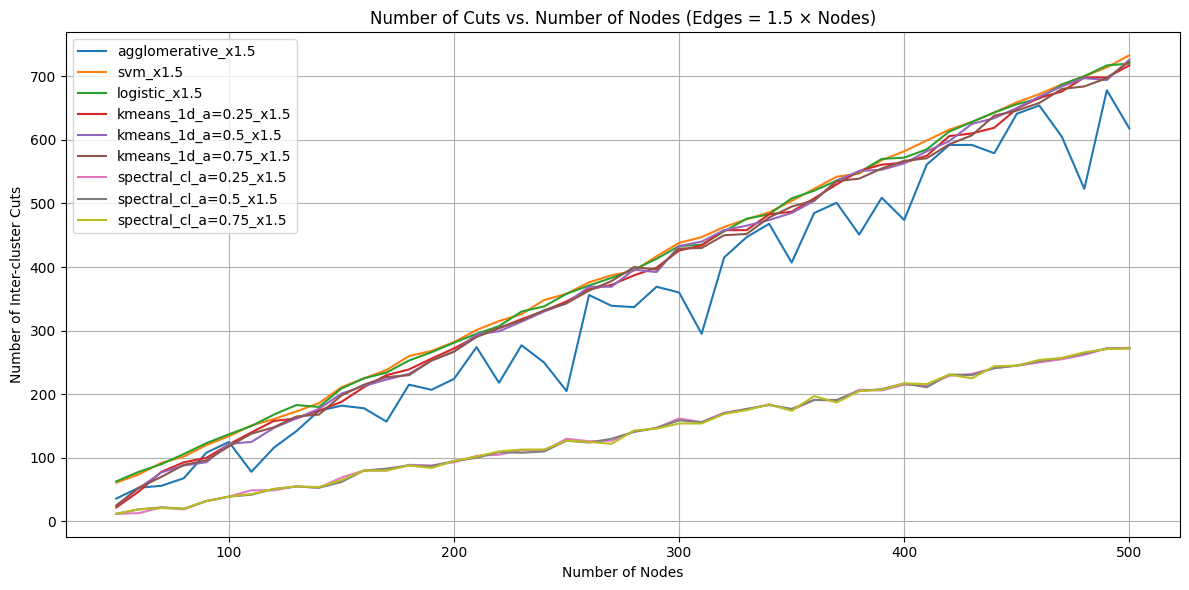

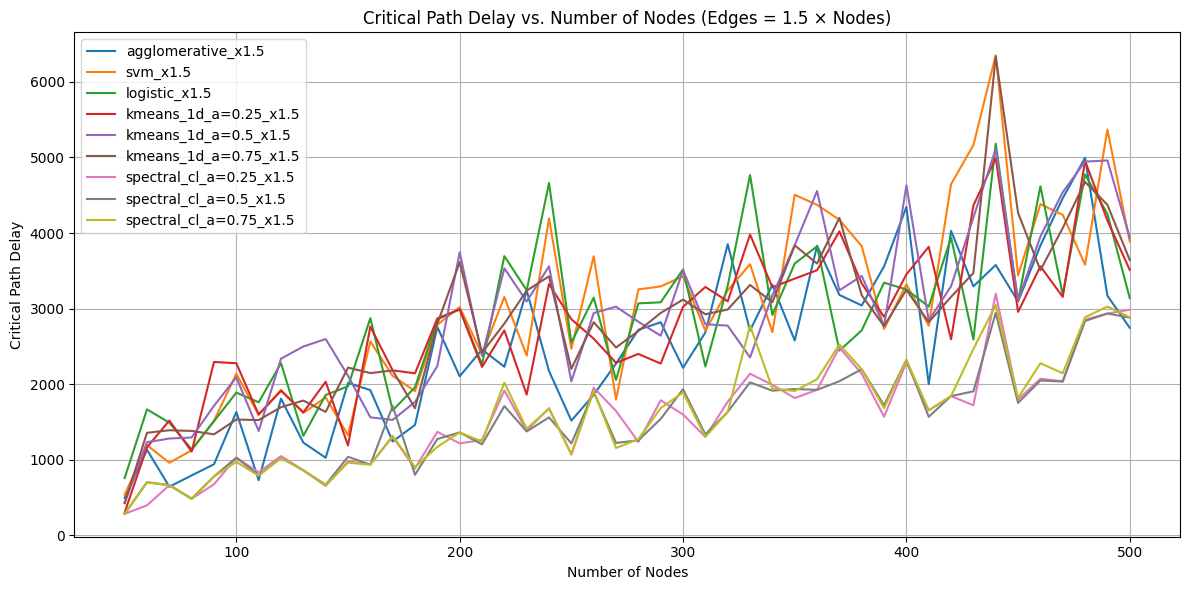

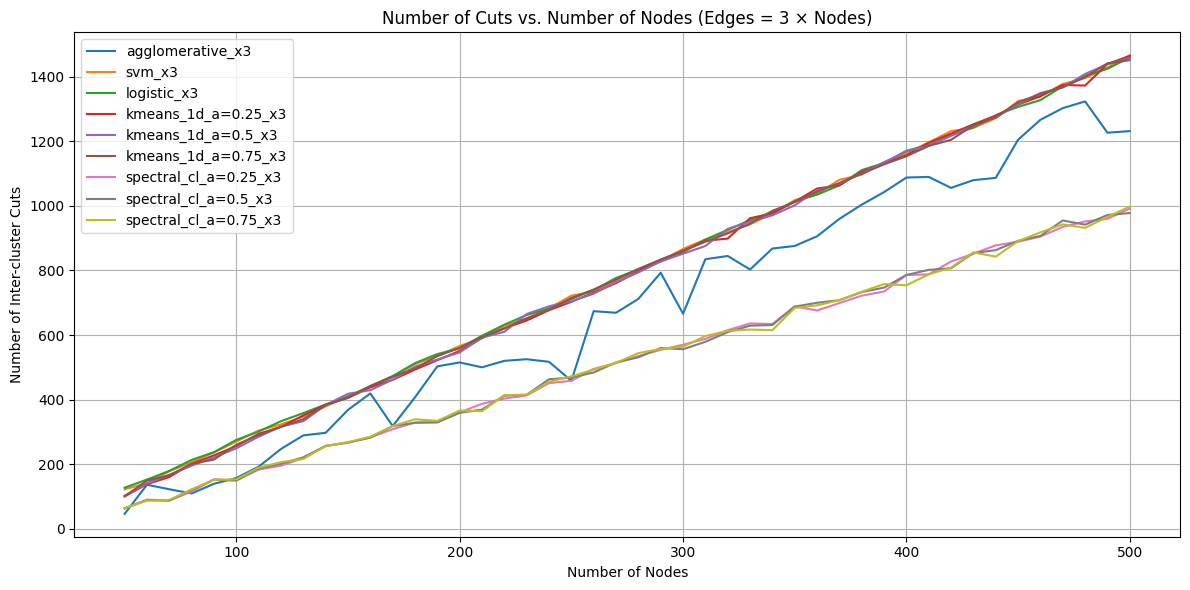

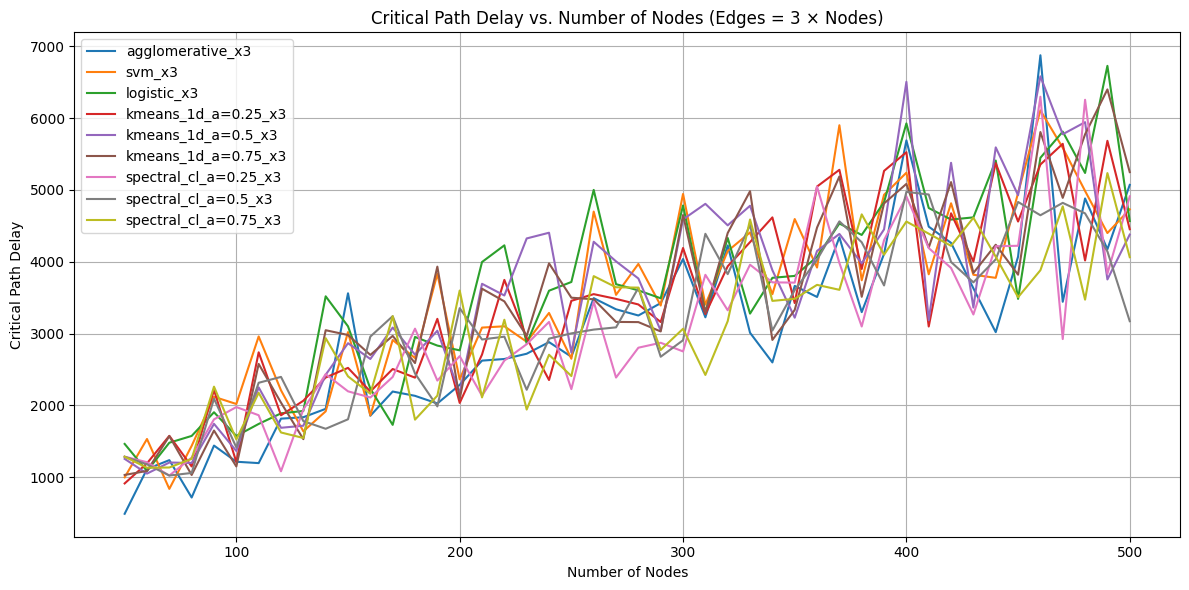

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding may not work as expected.")
model_dict = {
    "agglomerative": agglomerative_driver,
    "svm": svm_model_driver,
    "logistic": logistic_reg_driver,
    "kmeans_1d": KMeans_1D_driver,
    "spectral_cl": Spectral_cl_driver
}

scalability_analysis()

In [ ]:
for em in edge_multipliers:
    # Plot cuts
    plt.figure(figsize=(10, 6))
    for label in results:
        if label.endswith(f"_x{em}") and results[label]["nodes"]:
            plt.plot(results[label]["nodes"], results[label]["cuts"], label=label)
    plt.title(f"Inter-cluster Cuts vs. Number of Nodes (Edges = {em} × Nodes)")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Number of Cuts")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot delays
    plt.figure(figsize=(10, 6))
    for label in results:
        if label.endswith(f"_x{em}") and results[label]["nodes"]:
            plt.plot(results[label]["nodes"], results[label]["delays"], label=label)
    plt.title(f"Critical Path Delay vs. Number of Nodes (Edges = {em} × Nodes)")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Critical Path Delay")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
